**Overview**


*   The data used here is what we scraped from the "snscrape.ipynb" file
*   Scraping was done on local machine as Google Colab uses Python Version 3.6 as of the time this was published; snscrape only works with Pyhon 3.8 and above.



**Importing Libraries & Modules**

In [54]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import numpy as np
import re
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from plotly import graph_objs as go
from google.colab import drive
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import  PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer 
from scipy import sparse
from nrclex import NRCLex
import plotly.express as px

In [5]:
#Mount the google drive folder

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#Load the dataset

nairobi_df = pd.read_csv('/content/gdrive/My Drive/Coronavirus_Tweets/nairobi_county.csv')

#Preview the first four rows of the dataset

nairobi_df.head()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
0,0,0,2020-06-06 19:28:03+00:00,Mmetukosea sana! \n\nSasa ningeenda hadi pahal...,0,2
1,1,1,2020-06-06 13:25:27+00:00,CAN'T WAIT 🥰🥰 #6thjune #BlackLivesMatter #Curf...,1,10
2,2,2,2020-06-06 13:24:27+00:00,Wakenya hawachoki na meme za Uhuru😂😂 #UhuruKen...,1,4
3,3,3,2020-06-06 13:03:01+00:00,Fellow Kenyans #uhuruspeaks #UhuruAddress http...,0,1
4,4,4,2020-06-06 13:02:49+00:00,#UhuruKenyatta Cessation of movement in Nairob...,0,2


In [7]:
#Preview the last four rows of the dataset

nairobi_df.tail()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
8179,37,37,2020-05-29 06:20:25+00:00,President Uhuru Kenyatta made it clear that's ...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,#Uhurustoughchoices Mlisema huyu Ni mtoto wa N...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,Among other tough choices Uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,Pandemic. Perforated pockets. Plunging economy...,1,6
8183,41,41,2020-05-27 18:54:16+00:00,Pandemic. Perforated pockets. Plunging economy...,26,35


### Shape of the data

In [8]:
#number of rows and columns of the data

nairobi_df.shape

(8184, 6)

In [9]:
#Checking the data types of our data

""" This is crucial for modeling tasks. e.g when solving a regression problem, we only deal with numerical data types and not categorical. """

nairobi_df.dtypes

Unnamed: 0       int64
Unnamed: 0.1     int64
Datetime        object
Text            object
retweets         int64
likes            int64
dtype: object

**Cleaning the Data**

### Dealing with missing values

In [10]:
#Checking for missing values

""" If there are missing values in the columns, we either fill or drop them from the respective columns with too many missing values that are not of significance to the modeling task.

For this case, there are no missing values to handle."""

nairobi_df.isnull().sum()

Unnamed: 0      0
Unnamed: 0.1    0
Datetime        0
Text            0
retweets        0
likes           0
dtype: int64

In [11]:
#Checking for duplicates
print(nairobi_df.duplicated().any())

True


In [12]:
#Dropping Duplicates

nairobi_df.drop_duplicates(keep=False, inplace=True)

#Confirming there are no duplicates

print(nairobi_df.duplicated().any())
print(nairobi_df.shape)

False
(4214, 6)


### Dealing with Outliers

##### We check for outliers because often times, they result into an impbalanced data for modeling. i.e too many outliers bring about a high variance to our data. High variance causes overfitting to our model.

##### A Z score is used since our dataset consists of more than 30 rows.

In [13]:
#Dealing with outliers
#
#Import stats from scipy library

from scipy import stats
num = ['retweets']
for i, col in enumerate(num):
    z = np.abs(stats.zscore(nairobi_df[col]))
print(z)

[0.14138055 0.0583916  0.0583916  ... 0.10758628 0.0583916  2.016332  ]


In [14]:
#Confirming that our outliers have been dropped from the data set

nairobi_df2 = nairobi_df[( z < 2 )]

print(f"Previous dataframe size : {nairobi_df.shape[0]}" )
print(f"New dataframe size : {nairobi_df2.shape[0]}" )

Previous dataframe size : 4214
New dataframe size : 4173


In [15]:
nairobi_df2.describe()

,Unnamed: 0,Unnamed: 0.1,retweets,likes
count,4173.000000,4173.000000,4173.000000,4173.000000
mean,1358.447160,1358.447160,0.938414,3.865564
std,1011.783419,1011.783419,2.363796,11.781585
min,0.000000,0.000000,0.000000,0.000000
25%,444.000000,444.000000,0.000000,0.000000
50%,1195.000000,1195.000000,0.000000,1.000000
75%,2241.000000,2241.000000,1.000000,3.000000
max,3298.000000,3298.000000,25.000000,202.000000


**Cleaning the Text**

In [16]:
#Map the lowering function to all column names

nairobi_df2.columns = map(str.lower, nairobi_df2.columns)

#Print the column names

for col in nairobi_df2:
    print(col)

unnamed: 0
unnamed: 0.1
datetime
text
retweets
likes


In [17]:
#Removing Whitespace from both columns and rows and converting case to lower case
#
#Converting the text column to string dtype after getting an attribute error
"""nairobi_df2['text'] = nairobi_df2['text'].astype(str)

nairobi_df2.columns = nairobi_df2.str.strip().str.replace(",").str.lower()

cat = nairobi_df2['text']

for i, c in enumerate(cat):
    nairobi_df2[cat] = nairobi_df2[c].str.strip().str.replace(",").str.lower()"""

#Make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", '', text)
    text = re.sub("https?://\S+|www\.S+", '', text)
    text = re.sub("<.*?>+", '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation) , '', text)
    text = re.sub("\n", '', text)
    text = re.sub("\w*\d\w*", '', text)
    return text

In [18]:
#Using a lambda function to clean the text column

nairobi_df2['text'] = nairobi_df2['text'].apply(lambda x:clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
#Preview the dataset to see changes

nairobi_df2.tail()

,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes
8178,36,36,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0
8179,37,37,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,pandemic perforated pockets plunging economy p...,1,6


In [20]:
#Removing Stopwords

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

nairobi_df2['text_without_stopwords'] = nairobi_df2['text'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop))#this method gives back a list of words

nairobi_df2.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords
0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,mmetukosea sana sasa ningeenda hadi pahali gar...
1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,cant wait 🥰🥰 blacklivesmatter curfewinkenya wa...
2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...
3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,fellow kenyans uhuruspeaks uhuruaddress
4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,uhurukenyatta cessation movement nairobi momba...


In [21]:
#Check for the maximum and minimum dates in the data

print(f" Data Available since {nairobi_df2.datetime.min()}")
print(f" Data Available upto {nairobi_df2.datetime.max()}")

 Data Available since 2020-02-16 11:30:23+00:00
 Data Available upto 2020-07-22 03:35:10+00:00


**Visualizations**

### Common Words

In [22]:
#Checking for the most common words

from collections import Counter
nairobi_df2['text_without_stopwords'] = nairobi_df2['text_without_stopwords'].apply(lambda x:str(x).split())
top = Counter([item for sublist in nairobi_df2['text_without_stopwords'] for item in sublist])
tweets = pd.DataFrame(top.most_common(51))
tweets.columns = ['common words', 'count']
tweets.style.background_gradient(cmap = 'Blues')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,common words,count
0,stay,1602
1,safe,1413
2,staysafe,1394
3,curfewinkenya,593
4,stayhome,472
5,home,365
6,us,319
7,nairobi,306
8,amp,255
9,kenya,253


### Wordcloud

In [23]:
def plot_wordcloud(text, mask=None, max_words=500, max_font_size=100, figure_size=(14.0,6.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'sasa', "wa", 'wa', 'sana', 'hadi', 'na', 'huyu', 'ni',
                      'za', 'enga', 'mtoto'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/content/gdrive/My Drive/Coronavirus_Tweets/'

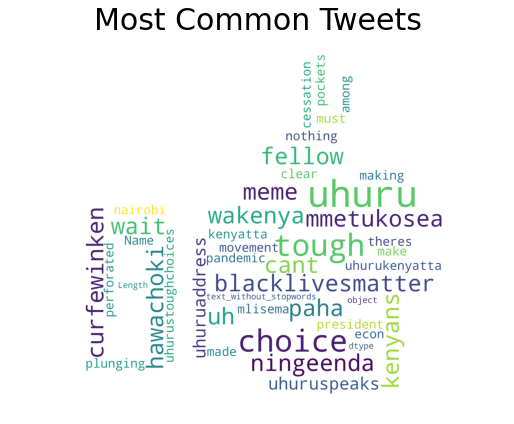

In [24]:
pos_mask = np.array(Image.open(d+ 'upvote.png'))
plot_wordcloud(nairobi_df2.text_without_stopwords,mask=pos_mask,color='white',max_font_size=300,title_size=30,title="Most Common Tweets")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



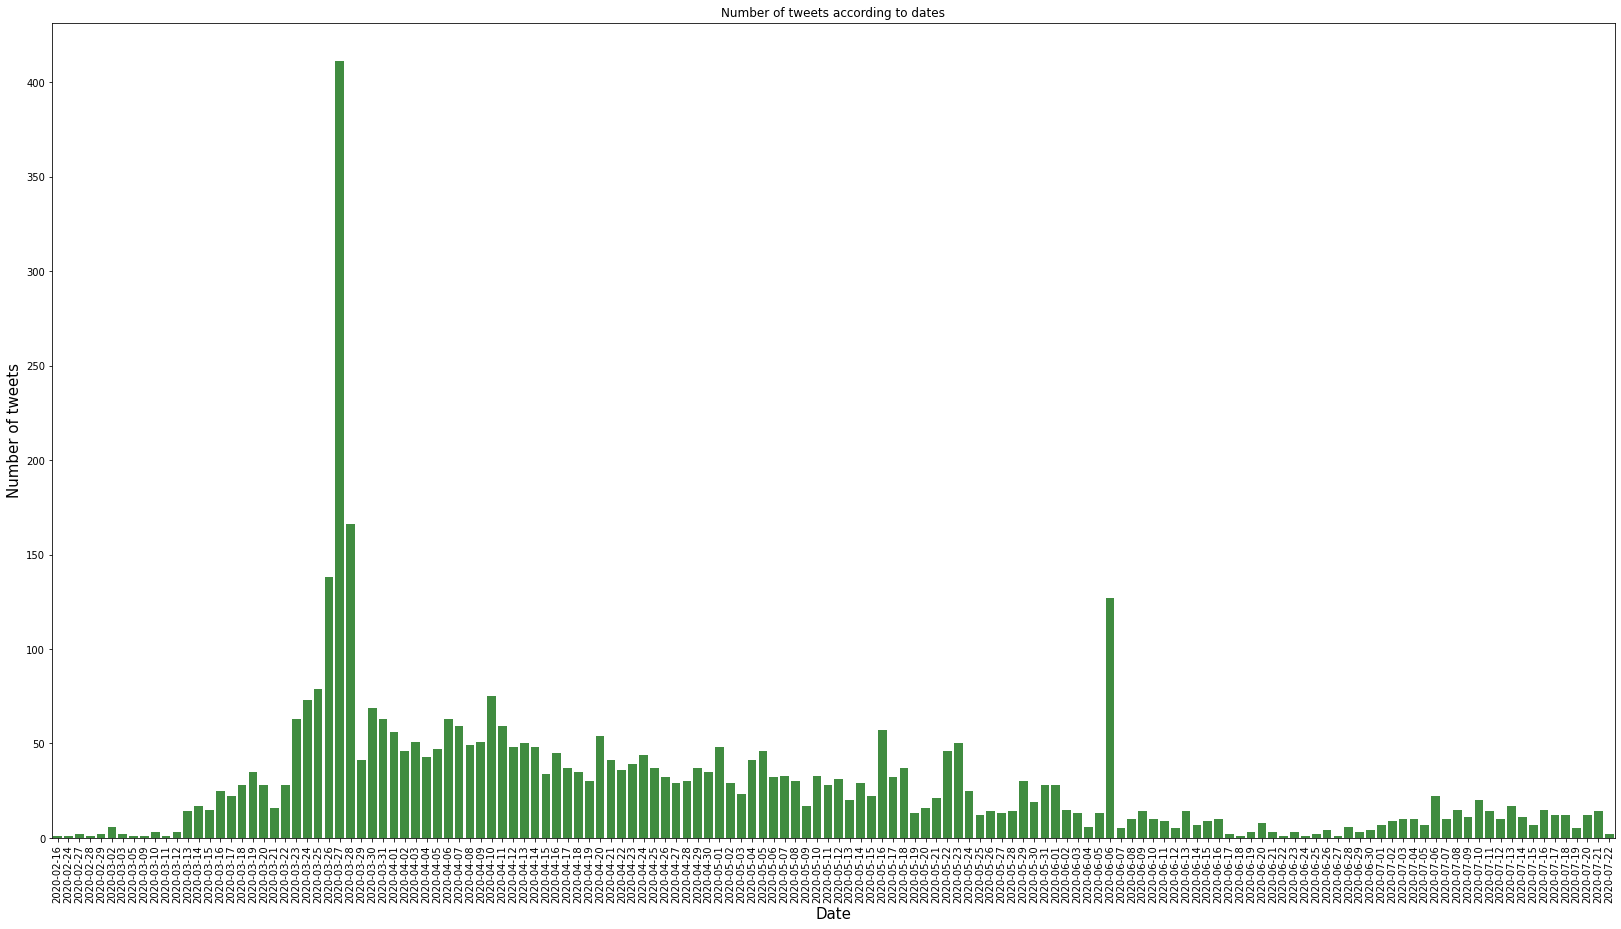

In [25]:
#The number of tweets according to dates

nairobi_df2['datetime'] =  pd.to_datetime(nairobi_df2['datetime'])
cnt_srs =nairobi_df2['datetime'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(28,15))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.title("Number of tweets according to dates")
plt.show()

# <center>**Bag of Words**</center>

### Procedure


*   Tokenize
*   Remove Stopwords
*   Lemmatization
*   Modeling with BOW
*   Split test and train data





In [26]:
#Tokenizing

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [27]:
#Save the dataframe to a csv file for Bag of Words

nairobi_df3 = nairobi_df2.to_csv('/content/gdrive/My Drive/Coronavirus_Tweets/bow.csv')

#Load the dataset
nairobi_df3 = pd.read_csv('/content/gdrive/My Drive/Coronavirus_Tweets/bow.csv')

#Preview the first few rows
nairobi_df3.head()

,Unnamed: 0,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords
0,0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h..."
1,1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu..."
2,2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '..."
3,3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd..."
4,4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na..."


In [28]:
#Dropping the unnamed columns

nairobi_df3.drop(['Unnamed: 0', 'unnamed: 0', 'unnamed: 0.1'], axis=1)

,datetime,text,retweets,likes,text_without_stopwords
0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h..."
1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu..."
2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '..."
3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd..."
4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na..."
...,...,...,...,...,...
4168,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0,"['theres', 'nothing', 'like', 'making', 'tough..."
4169,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2,"['president', 'uhuru', 'kenyatta', 'made', 'cl..."
4170,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0,"['uhurustoughchoices', 'mlisema', 'huyu', 'ni'..."
4171,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4,"['among', 'tough', 'choices', 'uhuru', 'must',..."


In [29]:
#Split the text column to create a new column, "text_list" then create a dataframe of two columns; "most_common_words" and "count"

nairobi_df3['text_list'] = nairobi_df3['text'].apply(lambda x:str(x).split()) #Use tokenize or split, smae results
top = Counter([item for sublist in nairobi_df3['text_list'] for item in sublist]) #Counts the frequency of words
temp = pd.DataFrame(top.most_common(6)) #top five words
temp.columns = ['common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,common_words,count
0,the,2159
1,to,1962
2,and,1725
3,stay,1602
4,safe,1413
5,staysafe,1394


In [30]:
#Check a summary of the data

nairobi_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4173 entries, 0 to 4172
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              4173 non-null   int64 
 1   unnamed: 0              4173 non-null   int64 
 2   unnamed: 0.1            4173 non-null   int64 
 3   datetime                4173 non-null   object
 4   text                    4173 non-null   object
 5   retweets                4173 non-null   int64 
 6   likes                   4173 non-null   int64 
 7   text_without_stopwords  4173 non-null   object
 8   text_list               4173 non-null   object
dtypes: int64(5), object(4)
memory usage: 293.5+ KB


In [31]:
#Check the Text_List column contents of first 20

nairobi_df3['text_list'][0:21]

0     [mmetukosea, sana, sasa, ningeenda, hadi, paha...
1     [cant, wait, 🥰🥰, blacklivesmatter, curfewinken...
2     [wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...
3          [fellow, kenyans, uhuruspeaks, uhuruaddress]
4     [uhurukenyatta, cessation, of, movement, in, n...
5     [tumeni, pombe, ni, sahau, hiyo, kizungu, ming...
6     [maryannwanguike, forget, uhuruaddressam, a, f...
7     [nationwide, dusk, to, dawn, curfew, extended,...
8                                        [uhuruaddress]
9     [uhuru, cessation, of, movement, of, eastleigh...
10    [free, delivery, in, ongata, rongai, karen, an...
11                         [here, we, go, uhuruaddress]
12                              [lol😅, 😂, uhuruaddress]
13    [kenya, will, be, green, againissues, affectin...
14    [that, to, purchase, locally, manufactured, ve...
15    [“money, in, the, hands, of, a, family, restor...
16    [president, uhuru, kenyatta, my, administratio...
17    [the, government, need, to, add, mind, you

In [32]:
#Check the length of the text_list column

len(nairobi_df3['text_list'])

4173

**Lemmatization & Stemming**

#### English Language stemmers: only identify with English language text


1.   Porter Stemmer; uses sufix stripping. does not keep a look-up table/dictionary for words
2.   Snowball Stemmer; more agressive than porter stemmer. **NB:** *You must specify that you want the english language texts coz it also has a dictionary of other words*

#### Other Language stemmers


1.   ISRI Stemmer; Arabic Language
2.   RSLP Stemmer; Portuguese Language
1.   Lancaster Stemmer - is heavy. requires good memory of computer resources.
2.   List item






In [33]:
#Preparing text for BOW: Remove stopwords & stem/Lemmatize

def prep_text(text):
  import nltk

  #Remove HTML tags
  my_text = BeautifulSoup(text, 'html.parser').get_text()

  #Tokenize words
  tokens = nltk.word_tokenize(my_text)

  #Define Stopwords
  stops = set(stopwords.words('english'))

  #Remove the stopwords
  words = [x for x in tokens if not x in stops]

  #Stemming
  stemmer = PorterStemmer()
  stemmed_words = []
  for i in range(0, len(words)):
    l2 = ' '.join([stemmer.stem(word) for word in words])
    stemmed_words.append(l2)

  #words = [nltk.SnowballStemmer('english').stem(w) for w in words]

  #Join the words back into one string separated by a space and return results
  return stemmed_words

In [34]:
#Performing iterative preps on each of the statements
nairobi_df3['text_stem'] = nairobi_df3['text'].apply(prep_text)

In [35]:
#View the stemmed words
nairobi_df3.sample(6)

,Unnamed: 0,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
1348,5338,495,495,2020-05-29 07:37:28+00:00,we love to see the excitement from our guests ...,1,5,"['love', 'see', 'excitement', 'guests', 'lose'...","[we, love, to, see, the, excitement, from, our...",[love see excit guest lose delici meal choic 😋...
2976,6971,2128,2128,2020-04-08 18:49:50+00:00,during this time of the world needs to come t...,0,1,"['time', 'world', 'needs', 'come', 'together',...","[during, this, time, of, the, world, needs, to...",[time world need come togeth stay safe iron co...
1354,5345,502,502,2020-05-28 19:23:52+00:00,aquaengnoq wishing you quick recovery dr majak...,0,2,"['aquaengnoq', 'wishing', 'quick', 'recovery',...","[aquaengnoq, wishing, you, quick, recovery, dr...",[aquaengnoq wish quick recoveri dr majak stay ...
942,4928,85,85,2020-07-14 09:38:24+00:00,hii corona imekita mizizi hapa nairobi treat e...,0,0,"['hii', 'corona', 'imekita', 'mizizi', 'hapa',...","[hii, corona, imekita, mizizi, hapa, nairobi, ...",[hii corona imekita mizizi hapa nairobi treat ...
91,91,54,54,2020-05-16 16:18:50+00:00,people of tana river are crying or medicines t...,0,1,"['people', 'tana', 'river', 'crying', 'medicin...","[people, of, tana, river, are, crying, or, med...",[peopl tana river cri medicin sad see countri ...
1326,5316,473,473,2020-05-30 13:28:18+00:00,sato alhamdulillah ukiskia johnte ni mteja le...,0,0,"['sato', 'alhamdulillah', 'ukiskia', 'johnte',...","[sato, alhamdulillah, ukiskia, johnte, ni, mte...",[sato alhamdulillah ukiskia johnt ni mteja leo...


In [36]:
#Dropping the unnamed columns

nairobi_df3.drop(['Unnamed: 0', 'unnamed: 0', 'unnamed: 0.1'], axis=1)


,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h...","[mmetukosea, sana, sasa, ningeenda, hadi, paha...",[mmetukosea sana sasa ningeenda hadi pahali ga...
1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu...","[cant, wait, 🥰🥰, blacklivesmatter, curfewinken...",[cant wait 🥰🥰 blacklivesmatt curfewinkenya wan...
2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '...","[wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...",[wakenya hawachoki na meme za uhuru😂😂 uhuruken...
3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd...","[fellow, kenyans, uhuruspeaks, uhuruaddress]","[fellow kenyan uhuruspeak uhuruaddress, fellow..."
4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na...","[uhurukenyatta, cessation, of, movement, in, n...",[uhurukenyatta cessat movement nairobi mombasa...
...,...,...,...,...,...,...,...
4168,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0,"['theres', 'nothing', 'like', 'making', 'tough...","[theres, nothing, like, making, a, tough, choi...",[there noth like make tough choic come open ec...
4169,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2,"['president', 'uhuru', 'kenyatta', 'made', 'cl...","[president, uhuru, kenyatta, made, it, clear, ...",[presid uhuru kenyatta made clear that engag c...
4170,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0,"['uhurustoughchoices', 'mlisema', 'huyu', 'ni'...","[uhurustoughchoices, mlisema, huyu, ni, mtoto,...",[uhurustoughchoic mlisema huyu ni mtoto wa nan...
4171,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4,"['among', 'tough', 'choices', 'uhuru', 'must',...","[among, other, tough, choices, uhuru, must, ma...",[among tough choic uhuru must make get compet ...


In [37]:
#Display the most common words after stemming

nairobi_df3['text_stem'] = nairobi_df3['text_stem'].apply(lambda x:str(x).split()) #Use tokenize or split, smae results
top = Counter([item for sublist in nairobi_df3['text_stem'] for item in sublist]) #Counts the frequency of words
temp = pd.DataFrame(top.most_common(21)) #top twenty words
temp.columns = ['common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,common_words,count
0,stay,20410
1,safe,15923
2,staysaf,14571
3,stayhom,6393
4,us,5988
5,’,5824
6,home,5739
7,amp,5348
8,"staysaf',",5111
9,curfewinkenya,4516


**Emotions**

In [68]:
#Convert the text_stem column to string type. nrclext only takes input of type str

nairobi_df3['text_stem'] = nairobi_df3['text_stem'].astype(str)

#Create a text object
text_object = NRCLex(' '.join(nairobi_df3['text_stem']))

#List emotional affect frequencies

text_object.affect_frequencies

{'anger': 0.015344784036372822,
 'anticip': 0.0,
 'anticipation': 0.10444556706238949,
 'disgust': 0.0126610255114928,
 'fear': 0.029237181106339986,
 'joy': 0.20743874715837332,
 'negative': 0.049223288709270015,
 'positive': 0.2769638797676181,
 'sadness': 0.018502147006819902,
 'surprise': 0.054496084869916646,
 'trust': 0.23168729477140693}

In [69]:
#Display the top emotions

text_object.top_emotions

[('positive', 0.2769638797676181)]

In [70]:
sentiment = sentiment_scores['Sentiment'].to_list()
sentiment

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'negative',
 'positive',
 'sadness',
 'surprise',
 'trust']

In [71]:
#Create a list from the  text object

sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items())) 

#Create a dataframe of two columns

sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
sentiment_scores

,Sentiment,Count
0,positive,8772
1,trust,7338
2,anger,486
3,fear,926
4,negative,1559
5,sadness,586
6,disgust,401
7,anticipation,3308
8,joy,6570
9,surprise,1726


In [72]:
#A Pie Chart of the sentiment sentiment_scores

fig = px.pie(sentiment_scores, values='Count', names='Sentiment',
             title='Sentiment Scores',
             hover_data=['Sentiment'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [73]:
#Create a dataframe with a dictionary of the sentiments

sentiment_words = pd.DataFrame(list(text_object.affect_dict.items()),columns = ['words','sentiments'])
sentiment_words

,words,sentiments
0,fellow,"[positive, trust]"
1,extend,[positive]
2,govern,"[positive, trust]"
3,question,[positive]
4,dear,[positive]
...,...,...
210,impress,[positive]
211,prophet,"[anticipation, positive, trust]"
212,fact,[trust]
213,trick,"[negative, surprise]"


In [75]:
for y in sentiment:
    sentiment_words[y] = 9
sentiment_words

,words,sentiments,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,fellow,"[positive, trust]",9,9,9,9,9,9,9,9,9,9
1,extend,[positive],9,9,9,9,9,9,9,9,9,9
2,govern,"[positive, trust]",9,9,9,9,9,9,9,9,9,9
3,question,[positive],9,9,9,9,9,9,9,9,9,9
4,dear,[positive],9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...
210,impress,[positive],9,9,9,9,9,9,9,9,9,9
211,prophet,"[anticipation, positive, trust]",9,9,9,9,9,9,9,9,9,9
212,fact,[trust],9,9,9,9,9,9,9,9,9,9
213,trick,"[negative, surprise]",9,9,9,9,9,9,9,9,9,9


In [78]:
a=0
for i in sentiment_words['sentiments']: 
    for y in sentiment:
        sentiment_words[y][a] = int(y in i)
    a=a+1

sentiment_words.tail(11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,words,sentiments,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
204,backward,[negative],0,0,0,0,0,1,0,0,0,0
205,chase,[negative],0,0,0,0,0,1,0,0,0,0
206,found,"[joy, positive, trust]",0,0,0,0,1,0,1,0,0,1
207,proud,"[anticipation, joy, positive, trust]",0,1,0,0,1,0,1,0,0,1
208,church,"[anticipation, joy, positive, trust]",0,1,0,0,1,0,1,0,0,1
209,assist,"[positive, trust]",0,0,0,0,0,0,1,0,0,1
210,impress,[positive],0,0,0,0,0,0,1,0,0,0
211,prophet,"[anticipation, positive, trust]",0,1,0,0,0,0,1,0,0,1
212,fact,[trust],0,0,0,0,0,0,0,0,0,1
213,trick,"[negative, surprise]",0,0,0,0,0,1,0,0,1,0


**Bag of words**

In [38]:
#Vectorize the texts

cv = CountVectorizer

corpus = nairobi_df3['text_stem']

cv = CountVectorizer(stop_words = 'english', analyzer = 'word') #ngram_range=(2,3) groupings can be specified using ngram
bow = cv.fit_transorm(corpus)

#view the vocabulary and frequency

cv.vocabulary_

AttributeError: ignored

In [ ]:
#get the feature names

cv.get_feature_names()

In [ ]:
#

cv_sparse = cv.fit_transform(nairobi_df3['text_stem'])
col = [i for i in cv.get_feature_names()]
temp = pd.DataFrame(cv_sparse.todense(), columns = col)
temp

In [ ]:
#Transform to an array

bow.toarray()